# Different architectures on MNIST classification

This notebook is based on the exercies provided in [Understanding Deep Learning (UDL)]((https://udlbook.github.io/udlbook/)) by David Prince. Specifically exercises 8.1 - MNIST-1D performance and  10.2 - Convolution for MNIST-1D. In these exercises the task was to first use a FNN and then CNN to classify MNIST-1D data and evalaute them using cross-entropy loss and %error. In accordance to the exercises in the book I also discussed my results.

## Setup

In [2]:
# Install MNIST 1D repository
#%pip install git+https://github.com/greydanus/mnist1d

In [3]:
# Imports
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import copy

## Fully connected, feedforward neural network

In [4]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [5]:
D_i = 40    # Input dimensions
D_1 = 285   # Hidden dimensions
D_2 = 135
D_3 = 60
D_o = 10    # Output dimensions

model_f = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_1),
    torch.nn.ReLU(),
    torch.nn.Linear(D_1, D_2),
    torch.nn.ReLU(),
    torch.nn.Linear(D_2, D_3),
    torch.nn.ReLU(),
    torch.nn.Linear(D_3, D_o))

def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

model_f


Sequential(
  (0): Linear(in_features=40, out_features=285, bias=True)
  (1): ReLU()
  (2): Linear(in_features=285, out_features=135, bias=True)
  (3): ReLU()
  (4): Linear(in_features=135, out_features=60, bias=True)
  (5): ReLU()
  (6): Linear(in_features=60, out_features=10, bias=True)
)

### Original Hyperparameters
Momentum = 0.9, Learning Rate = 0.05

In [6]:
model = copy.deepcopy(model_f)

# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train_f = torch.tensor(data['x'].astype('float32'))
y_train_f = torch.tensor(data['y'].transpose().astype('int64'))
x_test_f= torch.tensor(data['x_test'].astype('float32'))
y_test_f = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train_f,y_train_f), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
# steps per epoch = total examples / batch size = 4000 / 100 = 40
# number of epochs = total steps / steps per epoch = 100000 / 40 = 2500
n_epoch = 2500
# store the loss and the % correct at each epoch
losses_train_f = np.zeros((n_epoch))
errors_train_f = np.zeros((n_epoch))
losses_test_f = np.zeros((n_epoch))
errors_test_f = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train_f)
  pred_test = model(x_test_f)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train_f[epoch] = 100 - 100 * (predicted_train_class == y_train_f).float().sum() / len(y_train_f)
  errors_test_f[epoch]= 100 - 100 * (predicted_test_class == y_test_f).float().sum() / len(y_test_f)
  losses_train_f[epoch] = loss_function(pred_train, y_train_f).item()
  losses_test_f[epoch]= loss_function(pred_test, y_test_f).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_f[epoch]:.6f}, train error {errors_train_f[epoch]:3.2f},  test loss {losses_test_f[epoch]:.6f}, test error {errors_test_f[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.659192, train error 66.07,  test loss 1.712127, test error 68.10
Epoch     1, train loss 1.388585, train error 52.22,  test loss 1.506275, test error 63.20
Epoch     2, train loss 1.184083, train error 43.78,  test loss 1.347137, test error 53.50
Epoch     3, train loss 0.993600, train error 35.60,  test loss 1.262166, test error 48.50
Epoch     4, train loss 0.924714, train error 34.95,  test loss 1.272286, test error 51.20
Epoch     5, train loss 0.679277, train error 24.35,  test loss 1.084958, test error 41.20
Epoch     6, train loss 0.582480, train error 20.18,  test loss 1.101449, test error 40.10
Epoch     7, train loss 0.474950, train error 16.18,  test loss 1.100022, test error 39.00
Epoch     8, train loss 0.437255, train error 15.78,  test loss 1.171029, test error 40.80
Epoch     9, train loss 0.415848, train error 14.43,  test loss 1.208716, test error 37.80
Epoch    10, train loss 0.217658, train error 6.43,  test loss 1.065547, test error 34.20


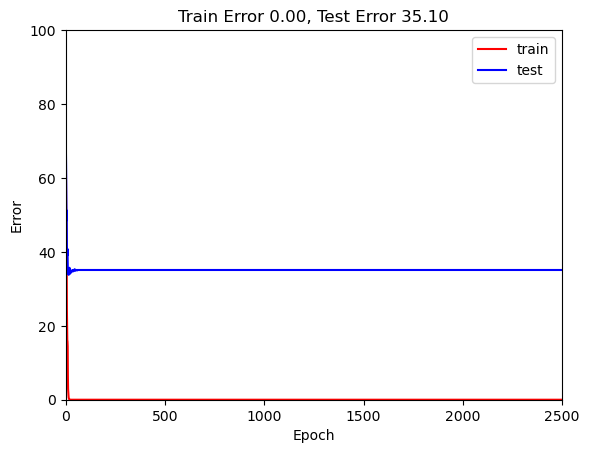

Min Train Error 0.00, Min Test Error 33.80


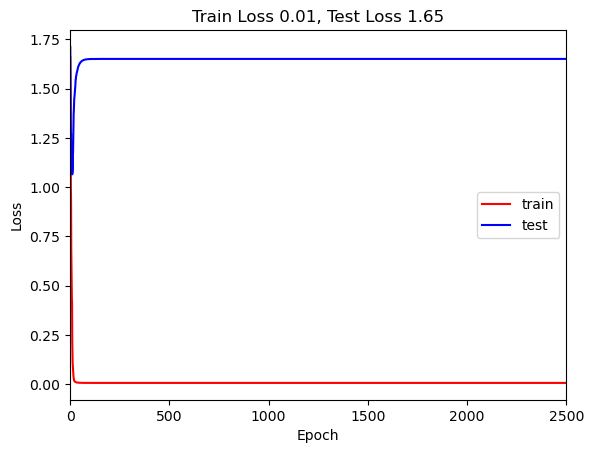

Min Train Loss 0.01, Min Test Loss 1.07


In [7]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train_f,'r-',label='train')
ax.plot(errors_test_f,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Train Error %3.2f, Test Error %3.2f'%(errors_train_f[-1],errors_test_f[-1]))
ax.legend()
plt.show()
print(f'Min Train Error %3.2f, Min Test Error %3.2f'%(min(errors_train_f),min(errors_test_f)))

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train_f,'r-',label='train')
ax.plot(losses_test_f,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train Loss %3.2f, Test Loss %3.2f'%(losses_train_f[-1],losses_test_f[-1]))
ax.legend()
plt.show()
print(f'Min Train Loss %3.2f, Min Test Loss %3.2f'%(min(losses_train_f),min(losses_test_f)))

I ran the scheduler for 2500 epochs, however the model converged somewhere between 20 and 50 epochs. Therefore from this point I will only run the model for 100 epochs and 50 epochs for hyperparameter tuning.

In [8]:
model = copy.deepcopy(model_f)

# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train_f = torch.tensor(data['x'].astype('float32'))
y_train_f = torch.tensor(data['y'].transpose().astype('int64'))
x_test_f= torch.tensor(data['x_test'].astype('float32'))
y_test_f = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train_f,y_train_f), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train_f = np.zeros((n_epoch))
errors_train_f = np.zeros((n_epoch))
losses_test_f = np.zeros((n_epoch))
errors_test_f = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train_f)
  pred_test = model(x_test_f)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train_f[epoch] = 100 - 100 * (predicted_train_class == y_train_f).float().sum() / len(y_train_f)
  errors_test_f[epoch]= 100 - 100 * (predicted_test_class == y_test_f).float().sum() / len(y_test_f)
  losses_train_f[epoch] = loss_function(pred_train, y_train_f).item()
  losses_test_f[epoch]= loss_function(pred_test, y_test_f).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_f[epoch]:.6f}, train error {errors_train_f[epoch]:3.2f},  test loss {losses_test_f[epoch]:.6f}, test error {errors_test_f[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.655176, train error 65.28,  test loss 1.750293, test error 70.10
Epoch     1, train loss 1.408231, train error 57.08,  test loss 1.548821, test error 63.00
Epoch     2, train loss 1.144810, train error 43.53,  test loss 1.402209, test error 53.20
Epoch     3, train loss 0.915599, train error 32.50,  test loss 1.218288, test error 48.10
Epoch     4, train loss 0.841359, train error 31.43,  test loss 1.218439, test error 47.00
Epoch     5, train loss 0.681563, train error 25.93,  test loss 1.217005, test error 47.10
Epoch     6, train loss 0.570250, train error 20.12,  test loss 1.101154, test error 40.20
Epoch     7, train loss 0.467799, train error 15.72,  test loss 1.110009, test error 41.20
Epoch     8, train loss 0.405158, train error 13.28,  test loss 1.066874, test error 39.20
Epoch     9, train loss 0.322806, train error 11.68,  test loss 1.252633, test error 40.30
Epoch    10, train loss 0.163379, train error 4.22,  test loss 1.091150, test error 35.00


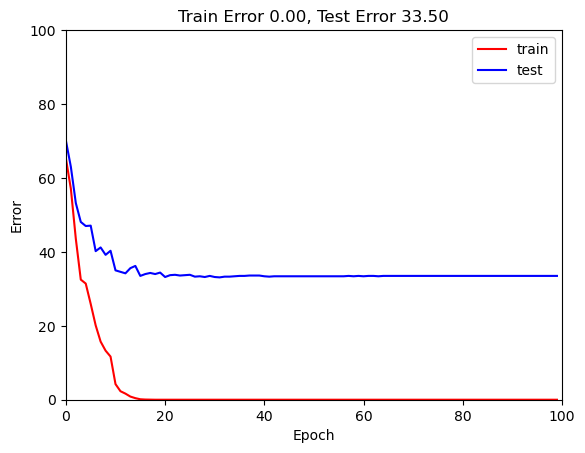

Min Train Error 0.00, Min Test Error 33.10


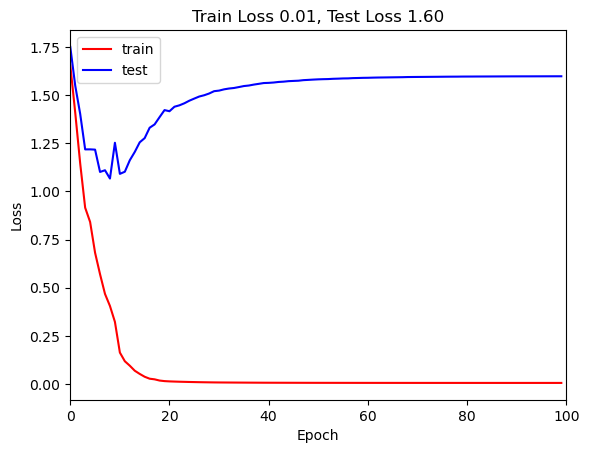

Min Train Loss 0.01, Min Test Loss 1.07


In [9]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train_f,'r-',label='train')
ax.plot(errors_test_f,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Train Error %3.2f, Test Error %3.2f'%(errors_train_f[-1],errors_test_f[-1]))
ax.legend()
plt.show()
print(f'Min Train Error %3.2f, Min Test Error %3.2f'%(min(errors_train_f),min(errors_test_f)))

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train_f,'r-',label='train')
ax.plot(losses_test_f,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train Loss %3.2f, Test Loss %3.2f'%(losses_train_f[-1],losses_test_f[-1]))
ax.legend()
plt.show()
print(f'Min Train Loss %3.2f, Min Test Loss %3.2f'%(min(losses_train_f),min(losses_test_f)))

### Hyperparameter Tuning

Grid search to find best hyperparameters

In [10]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()

min_train_loss = 10000

for learning_rate in [0.01, 0.03, 0.05, 0.07, 0.09]:
  for momentum in [0, 0.3, 0.6, 0.9, 1]:

    model = copy.deepcopy(model_f)

    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    x_train = torch.tensor(data['x'].astype('float32'))
    y_train = torch.tensor(data['y'].transpose().astype('int64'))
    x_test = torch.tensor(data['x_test'].astype('float32'))
    y_test = torch.tensor(data['y_test'].astype('int64'))

    # load the data into a class that creates the batches
    data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

    # Initialize model weights
    model.apply(weights_init)

    # loop over the dataset n_epoch times
    n_epoch = 50
    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))

    for epoch in range(n_epoch):
      # loop over batches
      for i, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch)
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

      # Run whole dataset to get statistics -- normally wouldn't do this
      pred_train = model(x_train_f)
      pred_test = model(x_test_f)
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_test_class = torch.max(pred_test.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
      losses_train[epoch] = loss_function(pred_train, y_train).item()
      losses_test[epoch]= loss_function(pred_test, y_test).item()
      # print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

      # tell scheduler to consider updating learning rate
      scheduler.step()
    
    print(f'({learning_rate:.2f}, {momentum:.2f}): min train loss {min(losses_train):.6f}, min test loss {min(losses_test):.2f}')

    if min(losses_train) < min_train_loss:
      best_params = (learning_rate, momentum)
      min_train_loss = min(losses_train)

print('best params: ' + str(best_params))

(0.01, 0.00): min train loss 0.007896, min test loss 1.02
(0.01, 0.30): min train loss 0.006849, min test loss 1.02
(0.01, 0.60): min train loss 0.006895, min test loss 1.04
(0.01, 0.90): min train loss 0.006166, min test loss 1.07
(0.01, 1.00): min train loss 0.007303, min test loss 1.07
(0.03, 0.00): min train loss 0.007734, min test loss 1.09
(0.03, 0.30): min train loss 0.006903, min test loss 1.07
(0.03, 0.60): min train loss 0.005568, min test loss 1.06
(0.03, 0.90): min train loss 0.007069, min test loss 0.99
(0.03, 1.00): min train loss 0.007291, min test loss 1.05
(0.05, 0.00): min train loss 0.006816, min test loss 1.02
(0.05, 0.30): min train loss 0.006247, min test loss 1.02
(0.05, 0.60): min train loss 0.006629, min test loss 1.03
(0.05, 0.90): min train loss 0.006882, min test loss 1.08
(0.05, 1.00): min train loss 0.005564, min test loss 1.03
(0.07, 0.00): min train loss 0.006144, min test loss 1.07
(0.07, 0.30): min train loss 0.007713, min test loss 1.03
(0.07, 0.60): 

Note: intuitively it would make more sense to train for a minimised test loss, however the task asked to train for a minimal training loss

### Results
* I implemented a basic grid search looping through learning rates and momentums to find the best training loss. I found all learning rate and momentum values investigated resulted in similar training losses with no clear improvements.

* The total number of parameters is calculated by summing input dimension * output dimension + bias for each layer in the model, which gives $(40 \cdot 285 + 285) + (285 \cdot 135 + 135) + (135 \cdot 60 + 60) + (60 \cdot 10 + 10) = 59065$ parameters.

* Throughout training, the training loss decreases with more epochs but the test loss has a minimum and increases afterwards due to over-fitting. The training loss converges to zero after some time. The test loss also converges to some value due to the weights no longer updating due to the the parameters being optimised on the test dataset.

## Convolutional neural network

### Original hyperparameters
Momentum = 0.9, Learning Rate = 0.08

In [11]:
model_c = torch.nn.Sequential(
    torch.nn.Conv1d(
      in_channels=1,
      out_channels=15,
      kernel_size=3,
      stride=2,
      padding=0
    ),
    torch.nn.ReLU(),
    torch.nn.Conv1d(
      in_channels=15,
      out_channels=15,
      kernel_size=3,
      stride=2,
      padding=0
    ),
    torch.nn.ReLU(),
    torch.nn.Conv1d(
      in_channels=15,
      out_channels=15,
      kernel_size=3,
      stride=2,
      padding=0
    ),
    torch.nn.Flatten(),
    torch.nn.Linear(60, 10),
    torch.nn.Softmax(dim=1))
   

def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

model_c

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,))
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=60, out_features=10, bias=True)
  (7): Softmax(dim=1)
)

Epoch     0, train loss 2.287551, train error 82.88,  val loss 2.286578, percent error 82.70
Epoch     1, train loss 2.196783, train error 78.45,  val loss 2.206283, percent error 78.60
Epoch     2, train loss 2.160195, train error 73.43,  val loss 2.181346, percent error 75.60
Epoch     3, train loss 2.118956, train error 64.28,  val loss 2.145323, percent error 68.80
Epoch     4, train loss 2.070565, train error 60.62,  val loss 2.097260, percent error 63.50
Epoch     5, train loss 2.051888, train error 59.45,  val loss 2.087574, percent error 64.60
Epoch     6, train loss 2.010463, train error 53.33,  val loss 2.054225, percent error 58.70
Epoch     7, train loss 2.009117, train error 54.72,  val loss 2.044924, percent error 58.90
Epoch     8, train loss 2.002418, train error 53.90,  val loss 2.038661, percent error 57.10
Epoch     9, train loss 1.976913, train error 51.62,  val loss 2.024733, percent error 57.30
Epoch    10, train loss 1.946164, train error 47.53,  val loss 1.98855

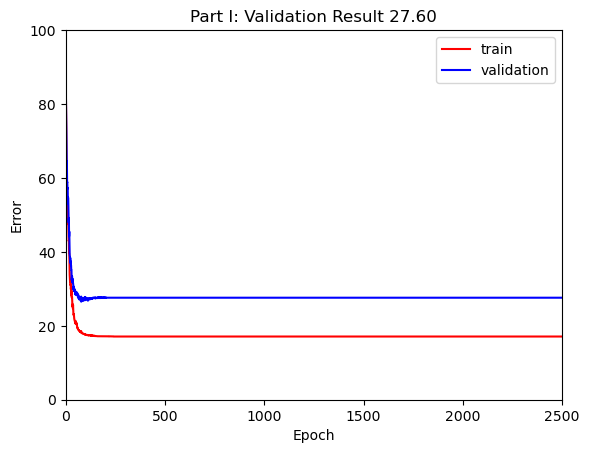

In [12]:
model = copy.deepcopy(model_c)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.08, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class

x_train_c = torch.tensor(data['x'].astype('float32'))
y_train_c = torch.tensor(data['y'].transpose().astype('int64'))
x_val_c= torch.tensor(data['x_test'].astype('float32'))
y_val_c = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train_c,y_train_c), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 2500
# store the loss and the % correct at each epoch
losses_train_c = np.zeros((n_epoch))
errors_train_c = np.zeros((n_epoch))
losses_val_c = np.zeros((n_epoch))
errors_val_c = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train_c[:,None,:])
  pred_val = model(x_val_c[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train_c[epoch] = 100 - 100 * (predicted_train_class == y_train_c).float().sum() / len(y_train_c)
  errors_val_c[epoch]= 100 - 100 * (predicted_val_class == y_val_c).float().sum() / len(y_val_c)
  losses_train_c[epoch] = loss_function(pred_train, y_train_c).item()
  losses_val_c[epoch]= loss_function(pred_val, y_val_c).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_c[epoch]:.6f}, train error {errors_train_c[epoch]:3.2f},  val loss {losses_val_c[epoch]:.6f}, percent error {errors_val_c[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train_c,'r-',label='train')
ax.plot(errors_val_c,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val_c[-1]))
ax.legend()
plt.show()

Epoch     0, train loss 2.262056, train error 85.35,  val loss 2.267649, percent error 85.50
Epoch     1, train loss 2.186344, train error 77.05,  val loss 2.198497, percent error 78.50
Epoch     2, train loss 2.143208, train error 69.50,  val loss 2.166749, percent error 73.30
Epoch     3, train loss 2.101712, train error 64.28,  val loss 2.127970, percent error 67.00
Epoch     4, train loss 2.055028, train error 58.00,  val loss 2.090035, percent error 62.50
Epoch     5, train loss 2.036433, train error 58.22,  val loss 2.070204, percent error 62.70
Epoch     6, train loss 2.020017, train error 54.50,  val loss 2.061423, percent error 59.80
Epoch     7, train loss 2.002380, train error 53.35,  val loss 2.044403, percent error 58.10
Epoch     8, train loss 1.982711, train error 51.45,  val loss 2.030048, percent error 57.60
Epoch     9, train loss 1.982609, train error 51.72,  val loss 2.033916, percent error 57.60
Epoch    10, train loss 1.992705, train error 53.70,  val loss 2.02143

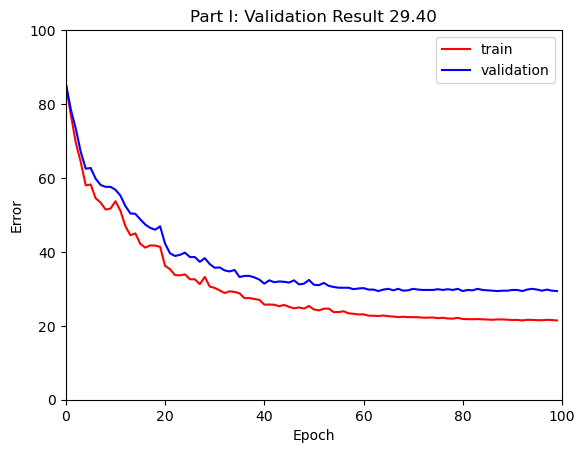

In [13]:
model = copy.deepcopy(model_c)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.08, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train_c = torch.tensor(data['x'].astype('float32'))
y_train_c = torch.tensor(data['y'].transpose().astype('int64'))
x_val_c= torch.tensor(data['x_test'].astype('float32'))
y_val_c = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train_c,y_train_c), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100

# store the loss and the % correct at each epoch
losses_train_c = np.zeros((n_epoch))
errors_train_c = np.zeros((n_epoch))
losses_val_c = np.zeros((n_epoch))
errors_val_c = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train_c[:,None,:])
  pred_val = model(x_val_c[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train_c[epoch] = 100 - 100 * (predicted_train_class == y_train_c).float().sum() / len(y_train_c)
  errors_val_c[epoch]= 100 - 100 * (predicted_val_class == y_val_c).float().sum() / len(y_val_c)
  losses_train_c[epoch] = loss_function(pred_train, y_train_c).item()
  losses_val_c[epoch]= loss_function(pred_val, y_val_c).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train_c[epoch]:.6f}, train error {errors_train_c[epoch]:3.2f},  val loss {losses_val_c[epoch]:.6f}, percent error {errors_val_c[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train_c,'r-',label='train')
ax.plot(errors_val_c,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val_c[-1]))
ax.legend()
plt.show()

### Hyperparameter Tuning

Grid search to find best hyperparameters

In [14]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()

min_train_loss = 10000

for learning_rate in [0.04, 0.06, 0.08, 0.1, 0.12]:
  for momentum in [0, 0.3, 0.6, 0.9, 1]:

    model = copy.deepcopy(model_c)
    
    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # object that decreases learning rate by half every 20 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    # create 100 dummy data points and store in data loader class
    x_train = torch.tensor(data['x'].astype('float32'))
    y_train = torch.tensor(data['y'].transpose().astype('int64'))
    x_val= torch.tensor(data['x_test'].astype('float32'))
    y_val = torch.tensor(data['y_test'].astype('int64'))

    # load the data into a class that creates the batches
    data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

    # Initialize model weights
    model.apply(weights_init)

    # loop over the dataset n_epoch times
    n_epoch = 50
    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_val = np.zeros((n_epoch))
    errors_val = np.zeros((n_epoch))

    for epoch in range(n_epoch):
      # loop over batches
      for i, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch[:,None,:])
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

      # Run whole dataset to get statistics -- normally wouldn't do this
      pred_train = model(x_train[:,None,:])
      pred_val = model(x_val[:,None,:])
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_val_class = torch.max(pred_val.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
      losses_train[epoch] = loss_function(pred_train, y_train).item()
      losses_val[epoch]= loss_function(pred_val, y_val).item()
      # print(f'Epoch {epoch:5d}, train loss {losses_train_c[epoch]:.6f}, train error {errors_train_c[epoch]:3.2f},  val loss {losses_val_c[epoch]:.6f}, percent error {errors_val_c[epoch]:3.2f}')

      # tell scheduler to consider updating learning rate
      scheduler.step()

    print(f'({learning_rate:.2f}, {momentum:.2f}): min train loss {np.min(losses_train):.6f}, min test loss {np.min(losses_val):.2f}')

    if min(losses_train) < min_train_loss:
      best_params = (learning_rate, momentum)
      min_train_loss = np.min(losses_train )

print('best params: ' + str(best_params))

(0.04, 0.00): min train loss 2.237380, min test loss 2.24
(0.04, 0.30): min train loss 2.196926, min test loss 2.21
(0.04, 0.60): min train loss 2.111966, min test loss 2.13
(0.04, 0.90): min train loss 1.941229, min test loss 1.98
(0.04, 1.00): min train loss 2.154020, min test loss 2.15
(0.06, 0.00): min train loss 2.176808, min test loss 2.19
(0.06, 0.30): min train loss 2.152978, min test loss 2.17
(0.06, 0.60): min train loss 2.059059, min test loss 2.08
(0.06, 0.90): min train loss 1.912261, min test loss 1.97
(0.06, 1.00): min train loss 2.240170, min test loss 2.24
(0.08, 0.00): min train loss 2.175590, min test loss 2.19
(0.08, 0.30): min train loss 2.102998, min test loss 2.13
(0.08, 0.60): min train loss 1.996575, min test loss 2.04
(0.08, 0.90): min train loss 1.796723, min test loss 1.86
(0.08, 1.00): min train loss 2.235045, min test loss 2.24
(0.10, 0.00): min train loss 2.139351, min test loss 2.16
(0.10, 0.30): min train loss 2.043441, min test loss 2.07
(0.10, 0.60): 

### Question 2
* I implemented another basic grid search looping through learning rates and momentums to find the best training loss. I found that all learning rates and momentum values investigated resulted in similar training losses with no clear improvements.

* The total number of hidden units is calculated by multiplying the dimensions of each hidden layer and summing them, which gives $(19 \cdot 15) + (9 \cdot 15) + (4 \cdot 15) = 480$

* The total number of parameters is calculated by summing kernel width * number of input channels * number of output channels + bias for each convolutional layer in the model and summing input dimension * output dimension + bias for the output layer, which gives $(3 \cdot 1 \cdot 15 + 15) + (3 \cdot 15 \cdot 15 + 15) + (3 \cdot 15 \cdot 15 + 15) + (60 \cdot 10 + 10) = 2050$ parameters.

* Throughout training, the training and test losses decrease with more epochs. The training loss decreases further but does not approach zero so we do not over-fit. Another indicator for this is that the test loss is always decreasing.

## Comparing architectures
### Question 3

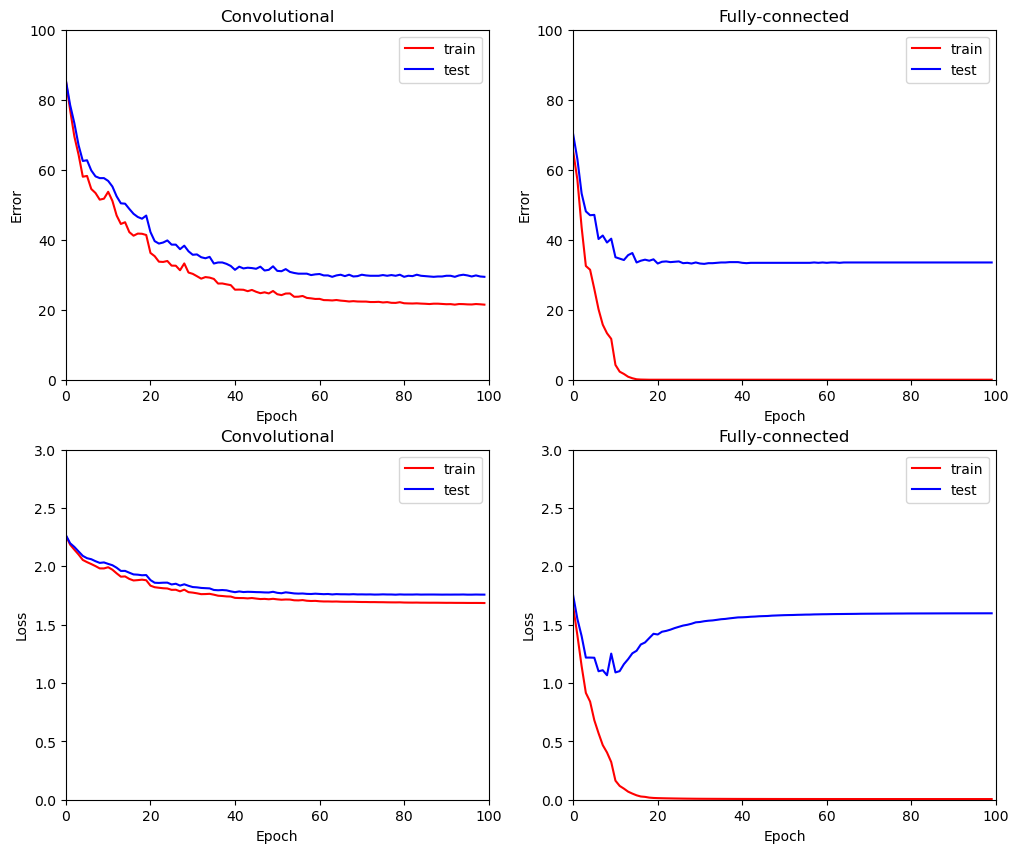

In [15]:
# Plot the results
fig, ax = plt.subplots(2,2,figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(errors_train_c, 'r-', label='train')
ax[0].plot(errors_val_c, 'b-', label='test')
ax[0].set_ylim(0, 100)
ax[0].set_xlim(0, 100)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Error')
ax[0].set_title(f'Convolutional')
ax[0].legend()

ax[1].plot(errors_train_f, 'r-', label='train')
ax[1].plot(errors_test_f, 'b-', label='test')
ax[1].set_ylim(0, 100)
ax[1].set_xlim(0, 100)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Error')
ax[1].set_title(f'Fully-connected')
ax[1].legend()

ax[2].plot(losses_train_c, 'r-', label='train')
ax[2].plot(losses_val_c, 'b-', label='test')
ax[2].set_ylim(0, 3)
ax[2].set_xlim(0, 100)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title(f'Convolutional')
ax[2].legend()

ax[3].plot(losses_train_f, 'r-', label='train')
ax[3].plot(losses_test_f, 'b-', label='test')
ax[3].set_ylim(0, 3)
ax[3].set_xlim(0, 100)
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_title(f'Fully-connected')
ax[3].legend()

Main differences between errors:
* Fully-connected model converges faster than convolutional model because the weights are independent and don't need to be shared across dimensions.
* Training error approaches zero for the fully-connected model, indicating overfitting, but not the convolutional model.
* Test error approaches a lower threshold for the convolutional model than the fully-connected model, indicating a better performance on an unseen dataset. 

Main differences between losses:
* Training and test losses for convolutional model both decrease whereas only the training loss decreases for the fully-connected model. The test loss initially decreases to a minima before increasing to a threshold again, indicating overfitting.
* Training loss does not approach zero for the convolutional model because we output a probability distribution instead of a definitive label. This is also the reason why the losses for the convolutional network are higher than the fully-connected network.

The convolutional neural network works better and it had lower test error. In general, CNNs have less parameters than a fully-connected neural network, which make them less likely to overfit to training data. Convolutional neural networks are better suited for dealing with images due to the convolutional layers. They also keep translational invariance and equivariance.